## References
###- https://www.kaggle.com/kevinarvai/knee-elbow-point-detection
###- https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
###- https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as clus
import time 
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from haversine import haversine,Unit
#!pip3 install kneed
from kneed import DataGenerator, KneeLocator
#from google.colab import files

## Import data

In [31]:
PATH_TO_ANALYSE="./Raw_data/points_from _2017-1-1_to_2019-12-31_weekdays_0_weekends_1.csv"
base_dataFrame=pd.read_csv(PATH_TO_ANALYSE)
base_dataFrame=base_dataFrame.drop(["Unnamed: 0"],axis=1)
base_dataFrame.head()

,lat,lon
0,45.049602,7.684859
1,45.048169,7.684837
2,45.070141,7.664186
3,45.069974,7.664980
4,45.064533,7.695944


## Plot with outliers

Text(0.5, 1.0, 'Map with outliers')

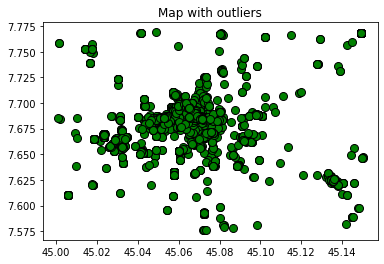

In [32]:
plt.plot(base_dataFrame["lat"], base_dataFrame["lon"], 'o', markerfacecolor="green", markeredgecolor='k', markersize=8)
plt.title("Map with outliers")

## Find a range of variation for epsilon (spannometric)

### Evaluate distances in meters (Haversine)

In [33]:
base_dataFrame=base_dataFrame.sort_values(by=['lat','lon'])
array_coordinates=base_dataFrame.to_numpy()
df_distances= pd.DataFrame(columns = ["index","distance"])

for i in range(len(array_coordinates)-1):
    point_1=array_coordinates[i,:]
    point_2=array_coordinates[i+1,:]
    distance=haversine(point_1,point_2,Unit.KILOMETERS) 
    df_distances=df_distances.append({"index":str(i),"distance":distance}, ignore_index=True)
df_distances=df_distances.sort_values(by=["distance"])
df_distances.shape

(5675, 2)


### Plot the elbow 

#### Find the knee

In [34]:
array_distances=df_distances.to_numpy(dtype = 'float')
indexes=array_distances[:,0]
distances=array_distances[:,1]
kneedle = KneeLocator(range(1,len(distances)+1), distances, S=1.0, curve="convex", direction="increasing",interp_method='polynomial')

#### Plot the knee

Text(0.5, 0, 'Index of point')

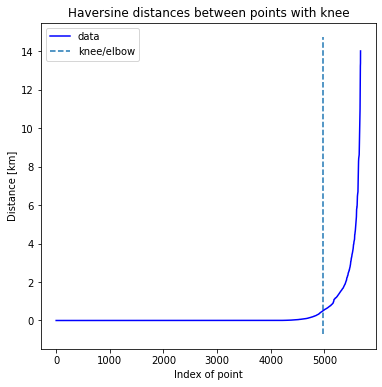

In [35]:
kneedle.plot_knee()
#plt.scatter(indexes,distances)
plt.title("Haversine distances between points with knee")
plt.ylabel("Distance [km]")
plt.xlabel("Index of point")

# DB-Scan method's tuning

#### Values that will be tested:

In [36]:
kms_per_radian = 6371.0088
e_t=kneedle.knee_y/kms_per_radian
M_t=np.arange(1,41,2)
kneedle.knee_y

0.5303183612252281

#### Collector of results:

In [37]:
list_of_parameters=[]

#### Convert coordinates to radians

In [38]:
coords = base_dataFrame.to_numpy()
radians_coords=np.radians(coords)

#### Start the tuning:

In [39]:
for M in M_t:
  try:
    db_clusters=clus.DBSCAN(eps=e_t, min_samples=M, metric='haversine',algorithm='ball_tree').fit(radians_coords)
    lab=db_clusters.labels_
    sil=silhouette_score(radians_coords,lab)
    n_noise_ = list(lab).count(-1)
    params={
      "silhouette":sil,
      "e":e_t,
      "M":M,
      "labels":lab
    }
    list_of_parameters.append(params)
  except:
    #print(f"With {e_t} as e and {M} as M only 1 cluster was generated")
    pass

#### Print the five best results:

In [40]:
list_of_parameters.sort(key=lambda el:el["silhouette"],reverse=True)
for el in list_of_parameters[:5]:
    n_clusters_ = len(set(el["labels"])) - (1 if -1 in el["labels"] else 0)
    n_noise_ = list(el["labels"]).count(-1)
    print("\nResult with e="+str(el["e"])+" and M="+str(el["M"])+":") 
    print("\tAverage silhouette:"+str(el["silhouette"])+"\n\tN° of clusters: "+str(len(set(lab)))+\
    "\n\tNumber of outliers: "+str(list(lab).count(-1)))


Result with e=8.323930759995626e-05 and M=17:
	Average silhouette:0.4137147088497863
	N° of clusters: 11
	Number of outliers: 428

Result with e=8.323930759995626e-05 and M=19:
	Average silhouette:0.4137147088497863
	N° of clusters: 11
	Number of outliers: 428

Result with e=8.323930759995626e-05 and M=21:
	Average silhouette:0.41042298874395644
	N° of clusters: 11
	Number of outliers: 428

Result with e=8.323930759995626e-05 and M=23:
	Average silhouette:0.40295415301274057
	N° of clusters: 11
	Number of outliers: 428

Result with e=8.323930759995626e-05 and M=27:
	Average silhouette:0.40234354787591164
	N° of clusters: 11
	Number of outliers: 428


## Run the method with the tuned params

In [41]:
db_clusters=clus.DBSCAN(eps=list_of_parameters[0]["e"], min_samples=list_of_parameters[0]["M"],metric='haversine',algorithm='ball_tree').fit(radians_coords)
lab=db_clusters.labels_
#These are parameters which will be usefull later on
core_samples_mask = np.zeros_like(lab, dtype=bool)
core_samples_mask[db_clusters.core_sample_indices_] = True

## Plot the results

Text(0.5, 1.0, 'Estimated number of clusters: 17')

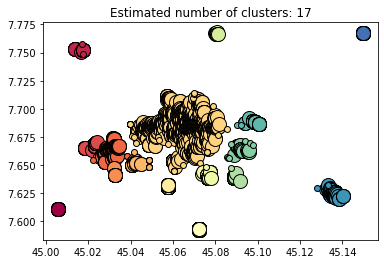

In [42]:
unique_labels = set(lab)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    if k!=-1:
      class_member_mask = (lab == k)
      xy = array_coordinates[class_member_mask & core_samples_mask]  
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=14)
      xy = array_coordinates[class_member_mask & ~core_samples_mask] 
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=6)
plt.title('Estimated number of clusters: %d' % len(unique_labels))

## Save results

In [43]:
longitudes=[]
latitudes=[]
cluster=[]
cores=[]

for k, col in zip(unique_labels, colors):
  class_member_mask = (lab == k)

  #Taking the core points first
  xy = array_coordinates[class_member_mask & core_samples_mask]
  longitudes+=list(xy[:,1])
  latitudes+=list(xy[:,0])
  listLabels=[lab[it] for it in range(len(lab)) if lab[it]==k and it in core_samples_mask]
  cluster+=listLabels
  cores+=[1 for it in range(len(xy[:,]))]

  #Then the others
  xy = array_coordinates[class_member_mask & ~core_samples_mask]
  longitudes+=list(xy[:,1])
  latitudes+=list(xy[:,0])
  listLabels=[lab[it] for it in range(len(lab)) if lab[it]==k and it not in core_samples_mask]
  cluster+=listLabels
  cores+=[0 for it in range(len(xy[:,]))]

csv_file={
"lng":longitudes,
"lat":latitudes,
"label":cluster,
"cores":cores
}

df2=pd.DataFrame(csv_file,columns=["lat","lng","label","cores"])

OUTPUT_NAME = "points_from _2017-1-1_to_2019-12-31_weekdays_0_weekends_1_labeled"
df2.to_csv(OUTPUT_NAME+"_"+str(round(kneedle.knee_y,2))+"_"+str(list_of_parameters[0]["M"])+".csv")

#files.download(OUTPUT_NAME)